# PROJECT NAME

---
## Import Relevant Libraries
---

In [152]:
import os.path

import pandas as pd
import tensorflow as tf
from fileMaster import *
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib.colors import ListedColormap, to_rgb
import numpy as np

-----
## Preliminary Cleaning | Clean ill-formated Data
-----

In [153]:
with open(raw_data_txt, 'r', encoding='utf-8') as f:
    raw_lines = f.readlines()

df = pd.DataFrame(columns=['Type', 'Msg'])

count = 0

for line in raw_lines:
    # Encode Sensitive Info
    line = line.replace("&lt;#&gt;", "[NUM]").replace(" [NUM] ", "[NUM]")
    line = line.replace("&lt;DECIMAL&gt;", "[DEC]").replace(" [DEC] ", "[DEC]")
    line = line.replace("&lt;URL&gt;", "[URL]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;TIME&gt;", "[TIME]").replace(" [URL] ", "[URL]")
    line = line.replace("&lt;EMAIL&gt;", "[EMAIL]").replace(" [EMAIL] ", "[EMAIL]")

    # Replace Known Strings
    line = line.replace("&lt;3", "[HEART]").replace(" [HEART] ", "[HEART]")
    line = line.replace("&lt;", "<")
    line = line.replace("&gt;", ">")
    line = line.replace("&amp;", "&")

    # Replace Special Characters
    line = line.replace("\x92", "'")
    line = line.replace("Bill said u or ur rents", 'Bill said u or ur parents')
    line = line.replace("MORROW", "TOMORROW")
    line = line.replace(" ", "")
    line = line.replace("ü", "u")
    line = line.replace("Ü", "U")
    line = line.replace("", "")
    line = line.replace("", " ")

    # Replace Unknown Characters
    line = line.replace("鈥┾??〨ud", "[UNK]")

    _lst = line.split('\t')
    _type = _lst[0]
    _msg = _lst[1].strip()

    d = {'Type': _type, 'Msg': _msg}
    df2 = pd.DataFrame(d, [count])

    df = pd.concat([df, df2], axis=0)

    count += 1

df.to_csv(data_folder / 'cleaned.csv', sep=',', encoding='utf-8', index=False)

In [154]:
df.head()

,Type,Msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


---
## Verify Tensorflow GPU is Identified
---

In [155]:
if tf.test.gpu_device_name():

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


---
## Exploratory Data Analysis
---

### <blockquote>Basic Statistics

In [156]:
df.groupby("Type").describe()

Msg                                                               
     count unique                                                top freq
Type                                                                     
ham   4827   4518                             Sorry, I'll call later   30
spam   747    642  Please call our customer service representativ...    4

In [157]:
eda_type_count_df = pd.DataFrame({'Count': [df['Type'].value_counts()['ham'], df['Type'].value_counts()['spam']], 'Type': ['Ham', 'Spam']}, ['Ham', 'Spam'])
eda_type_count_fig = px.bar(eda_type_count_df, x='Type', y='Count', orientation='v', color_discrete_sequence=["#A0e7A0", "#FF8986"], color='Type', title='Count of Message Types', text_auto='', template='plotly')
eda_type_count_fig.show()

The number of datapoints is skewed heavily in favor of Ham messages. This is unsurprising, given that on a daily basis most people receive more ham than spam. However, this may lead to potential implicit biasness in our models. Hence, we will be using our models on a balanced dataset and the original to determine the effects of such a skew.

### <blockquote>Tokenization

In [158]:
def tokenization(msg, punc_remove=False):
    punct_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ]

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]

            if punc_remove:
                strng = f' '.join(temp_lst)
            else:
                strng = f' {p} '.join(temp_lst)

    word_lst = strng.split(' ')

    if not punc_remove:
        count = 0

        punct_lst.remove('..')
        punct_lst.remove('...')

        for w in word_lst:
            try:
                for p in punct_lst:
                    if  w == 2*p and word_lst[count+1] == p:
                        word_lst[count] = 3*p
                        word_lst.pop(count + 1)
            except IndexError:  
                '''
                Index error occurs when we are at the last element of list and 
                try to access the next element, this means that the ".." is at the 
                last element so we do not to do anything abt it
                
                '''
                pass

            count += 1

    return word_lst

Above is our own function to tokenize the words in the messages.

In [159]:
def split_sentence(msg):
    punct_lst = ['...', '..', '.', '?', '!', ';']

    strng = msg

    for p in punct_lst:

        if ('..'  in strng or '...' in strng) and p == '.':
            pass
        else:
            temp_lst = strng.split(p)
            temp_lst = [x.rstrip() for x in temp_lst]
            temp_lst = [x.lstrip() for x in temp_lst]
            strng = f'|'.join(temp_lst)

    sentence_lst = strng.split('|')

    sym_lst = ['...', '..', ",", '.', ';', '<', '>', '/', '"', '&', '!', '@', '#', '?', ' ', '']
    for s in sentence_lst:
        if s in sym_lst:
            sentence_lst.remove(s)

    return sentence_lst

Above is our own function to tokenize the sentences in the messages.

In [160]:
# Tokenize Characters
df['CharCount'] = df['Msg'].apply(lambda x: len(x))

# Tokenize Words
df['ListWords'] = df['Msg'].apply(lambda x: tokenization(x))
df['NumWords'] = df['Msg'].apply(lambda x: len(tokenization(x, punc_remove=True)))

# Tokenize Sentences
df['ListSentence'] = df['Msg'].apply(lambda x: split_sentence(x))
df['NumSentences'] = df['Msg'].apply(lambda x: len(split_sentence(x)))

In [161]:
df.head()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1


First 5 messages and their character, words and sentences tokenized and counted.

In [162]:
df.tail()

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences
5569,spam,This is the 2nd time we have tried 2 contact u...,160,"[This, is, the, 2nd, time, we, have, tried, 2,...",30,[This is the 2nd time we have tried 2 contact ...,5
5570,ham,Will u b going to esplanade fr home?,36,"[Will, u, b, going, to, esplanade, fr, home, ?, ]",9,[Will u b going to esplanade fr home],1
5571,ham,"Pity, * was in mood for that. So...any other s...",57,"[Pity, ,, *, was, in, mood, for, that., So, .....",12,"[Pity, * was in mood for that, So, any other s...",3
5572,ham,The guy did some bitching but I acted like i'd...,125,"[The, guy, did, some, bitching, but, I, acted,...",26,[The guy did some bitching but I acted like i'...,1
5573,ham,Rofl. Its true to its name,26,"[Rofl, ., Its, true, to, its, name]",6,"[Rofl, Its true to its name]",2


Last 5 messages and their character, words and sentences tokenized and counted.

### <blockquote> Histograms of *CharCount*, *NumWords*, *NumSentence*

In [163]:
eda_charc_hist = px.histogram(df[['CharCount', 'Type']], x='CharCount', color='Type', template='plotly', title='Histogram on Number of Characters', color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** character count (i.e. the mode of spam messages lies between 155-159 characters) than ham messages (i.e. mode of ham messages lies between 25-29 characters). Furthermore, the distribution of ham messages is **positively** skewed, whereas that of spam messages is **negatively** skewed.

In [164]:
eda_charc_hist = px.histogram(df[['NumWords', 'Type']], x='NumWords', color='Type', template='plotly', title='Histogram on Number of Words', color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

It is interesting note that most **spam** messages have a **higher** word count (i.e. the mode of spam messages lies at 28 words) than ham messages (i.e. mode of ham messages lies at 6 words). Furthermore, the two distributions of CharCount and NumWords look fairly similar in shape. Hence, the distribution of ham messages is still **positively** skewed, whereas that of spam messages is still **negatively** skewed.

In [165]:
eda_charc_hist = px.histogram(df[['NumSentences', 'Type']], x='NumSentences', color='Type', template='plotly', title='Histogram on Number of Sentences', color_discrete_sequence=["#A0e7A0", "#FF8986"])
eda_charc_hist.update_layout(barmode='overlay')

**Visually**, it is interesting to note that the **distribution** of **spam** messages **seem to follow a Normal Distribution**, with the mode of **spam** messages being at 3, which is significantly higher than that of **ham** messages (whose mode lies at 1 sentence). It is also unsurprising that the distribution of **ham** messages have a **positive** skew, considering that most people will limit their text to around a sentence in this day and age. Hence, our group postulates that, **ceteris paribus**, the **likelihood** of a message being a **spam** message is high should there be 3-4 sentences.

### <blockquote> Box-Plots of *CharCount*, *NumWords*, *NumSentence*

In [166]:
def genBoxPlot(var):
    box_fig = go.Figure()
    box_fig.layout.title = f'Box-Plots of Spam and Ham for {var}'
    ham_df = df[df['Type']=='ham']
    temp_df = df

    temp_df['Ham'] = ham_df[var]
    spam_df = df[df['Type']=='spam']
    temp_df['Spam'] = spam_df[var]


    for col in temp_df[['Ham', 'Spam']]:
        box_fig.add_trace(
            go.Box(x=temp_df[col].values,
                   name=temp_df[col].name,
                   fillcolor=["#CEF3CE", "#FFEBEB"][['Ham', 'Spam'].index(col)],
                   line={'color': ["#6BDB6B", "#FF8986"][['Ham', 'Spam'].index(col)]}
                   )
        )
    box_fig.update_traces(orientation='h')
    box_fig.show()
    return temp_df

Above is our own function to generate the box-plots for the various types of counts and their type of message.

In [167]:
# Call function to generate Box-Plots for CharCount, NumWords and NumSentences

genBoxPlot('CharCount')
genBoxPlot('NumWords')
genBoxPlot('NumSentences')

,Type,Msg,CharCount,ListWords,NumWords,ListSentence,NumSentences,Ham,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...",20,"[Go until jurong point, crazy, Available only ...",3,3.0,NaN
1,ham,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",6,"[Ok lar, Joking wif u oni]",2,2.0,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",29,[Free entry in 2 a wkly comp to win FA Cup fin...,2,NaN,2.0
3,ham,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",11,"[U dun say so early hor, U c already then say]",2,2.0,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, don't, think, he, goes, to, usf, ,, h...",13,"[Nah I don't think he goes to usf, he lives ar...",1,1.0,NaN
...,...,...,...,...,...,...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,160,"[This, is, the, 2nd, time, we, have, tried, 2,...",30,[This is the 2nd time we have tried 2 contact ...,5,NaN,5.0
5570,ham,Will u b going to esplanade fr home?,36,"[Will, u, b, going, to, esplanade, fr, home, ?, ]",9,[Will u b going to esplanade fr home],1,1.0,NaN
5571,ham,"Pity, * was in mood for that. So...any other s...",57,"[Pity, ,, *, was, in, mood, for, that., So, .....",12,"[Pity, * was in mood for that, So, any other s...",3,3.0,NaN
5572,ham,The guy did some bitching but I acted like i'd...,125,"[The, guy, did, some, bitching, but, I, acted,...",26,[The guy did some bitching but I acted like i'...,1,1.0,NaN


**ANALYSIS OF BOX-PLOTS COMING SOON** REFER TO LECTURE NOTE CHAPTER 4 FOR THE DIFF IN BOXPLOT MEANS GOT RELATION BLAH BLAH BLAH



### <blockquote> Scatter Plots of *CharCount*, *NumWords*, *NumSentence*

In [168]:
scatter_plot = px.scatter_matrix(df,
                                 dimensions=["CharCount", "NumWords", "NumSentences"],
                                 color = "Type",
                                 template = 'plotly',
                                 color_discrete_map = {'ham': '#6BDB6B', 'spam': '#FF8986'},
                                 title = "Pair Plot of all 3 Features",
                                 )
scatter_plot.update_traces(diagonal_visible=False)
scatter_plot.show()

##### LINK BACK TO R/S with Histogram. Similarity between words and char shape but not sentences
**ANALYSIS OF SCATTER PLOTS COMING SOON**

### <blockquote> Correlation Matrix Between *CharCount*, *NumWords*, *NumSentence*

In [169]:
def genCorrMatrix(type_msg):
    corr_df = df[df['Type']==type_msg]
    corr_df = corr_df[['CharCount', 'NumWords', 'NumSentences']]
    fig = px.imshow(corr_df.corr(),
                    text_auto=True,
                    color_continuous_scale = 'reds',
                    template = 'plotly_white',
                    title = f"Correlation Matrix for {type_msg} msgs")
    fig.show()

In [170]:
genCorrMatrix('ham')
genCorrMatrix('spam')

**ANALYSIS OF CORRELATION MATRIX COMING SOON**

#### Binary Classification Tree


In [171]:
# Train-test Split
predictors = ['CharCount', 'NumWords', 'NumSentences']

pushThrough = True
default = False

if (not os.path.isfile(x_train_csv)) or default or not pushThrough:
    x = df[predictors]
    y = pd.DataFrame(df['Type'].astype('category'))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

    # Save CSV
    if not os.path.isdir(train_test_folder):
        os.makedirs(train_test_folder)
    x_train.to_csv(x_train_csv, index=False)
    y_train.to_csv(y_train_csv, index=False)
    x_test.to_csv(x_test_csv, index=False)
    y_test.to_csv(y_test_csv, index=False)
else:
    # Load CSV
    x_train = pd.read_csv(x_train_csv)
    y_train = pd.read_csv(y_train_csv)
    x_test = pd.read_csv(x_test_csv)
    y_test = pd.read_csv(y_test_csv)

In [172]:
x_train.head()

,CharCount,NumWords,NumSentences
0,23,4,1
1,125,26,5
2,158,37,6
3,65,12,2
4,27,7,1


In [173]:
def genDecTree(depth, _x_train, _x_test, _y_train, _y_test):
    decTree = DecisionTreeClassifier(max_depth = depth)  # create the decision tree object
    decTree.fit(_x_train, _y_train)                    # train the decision tree model

    # Plot Tree
    if depth == 2:
        width = 25
        font_size = 25
    elif depth == 4:
        width = 80
        font_size = 30
    elif depth == 6:
        width = 240
        font_size = 40
    elif depth == 10:
        width = 240
    height = width / 2

    fontsize = depth*12.5

    colors = ['lightgreen', 'salmon']

    if depth < 6:
        plt.figure(figsize=(width,height))
        t = tree.plot_tree(decTree, filled=True, rounded=True, feature_names=_x_train.columns,
                           class_names=["Ham", "Spam"], fontsize=font_size)

        for a, impurity, value in zip(t, decTree.tree_.impurity, decTree.tree_.value):
            # let the max value decide the color; whiten the color depending on impurity (gini)
            r, g, b = to_rgb(colors[np.argmax(value)])
            _c = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
            a.get_bbox_patch().set_facecolor((_c + (1-_c)*r, _c + (1-_c)*g, _c + (1-_c)*b))
            a.get_bbox_patch().set_edgecolor('black')

        plt.savefig(f'depth_{depth}_decTree.png')

    # Predict Response corresponding to Predictors
    y_train_pred = decTree.predict(_x_train)
    y_test_pred = decTree.predict(_x_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_train, _y_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", decTree.score(_x_test, _y_test))


    # Plot the Confusion Matrix for Train and Test
    train_fig = px.imshow(confusion_matrix(y_train, y_train_pred), text_auto=True, color_continuous_scale = 'reds',
                          template = 'plotly_white', title = f"Confusion Matrix for Train set, depth {depth}")
    test_fig = px.imshow(confusion_matrix(y_test, y_test_pred), text_auto=True, color_continuous_scale = 'reds',
                         template = 'plotly_white', title = f"Confusion Matrix for Test set, depth {depth}")
    train_fig.show()
    test_fig.show()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8988038277511962

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8895265423242468


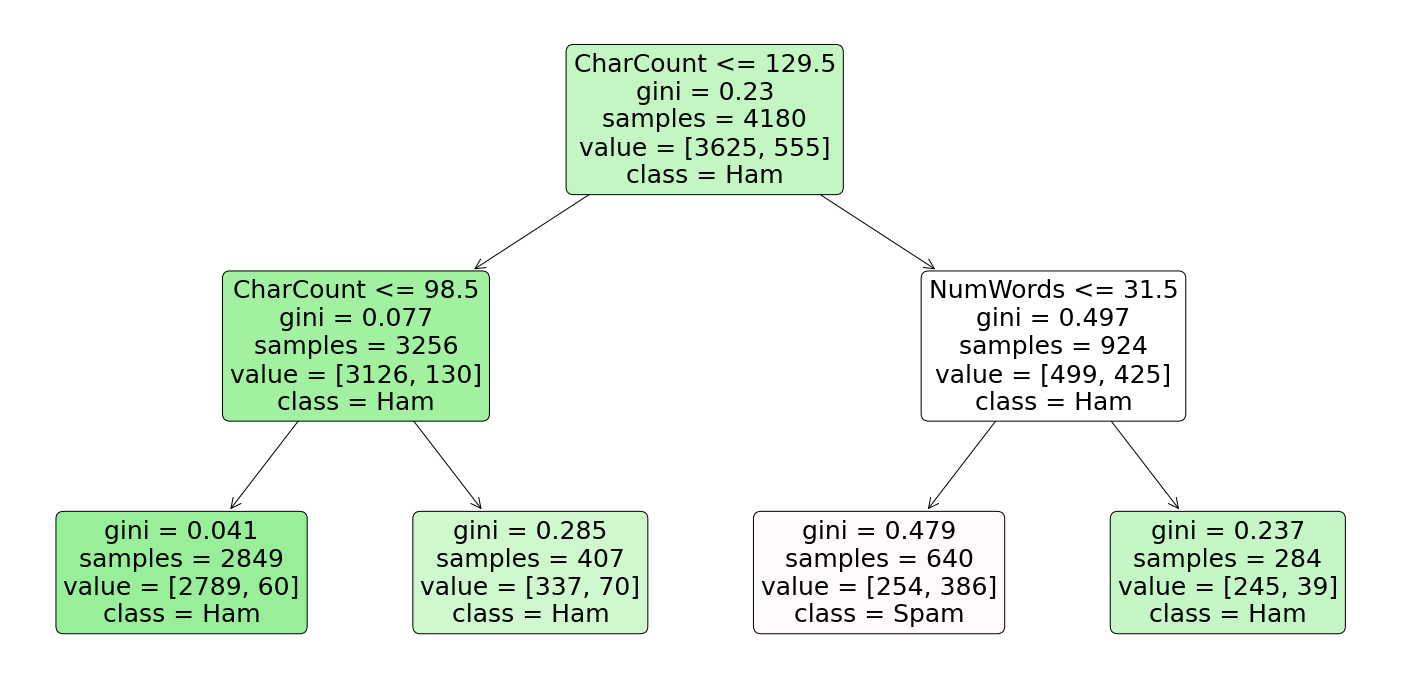

In [174]:
# Depth 2
genDecTree(2, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9055023923444976

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9067431850789096


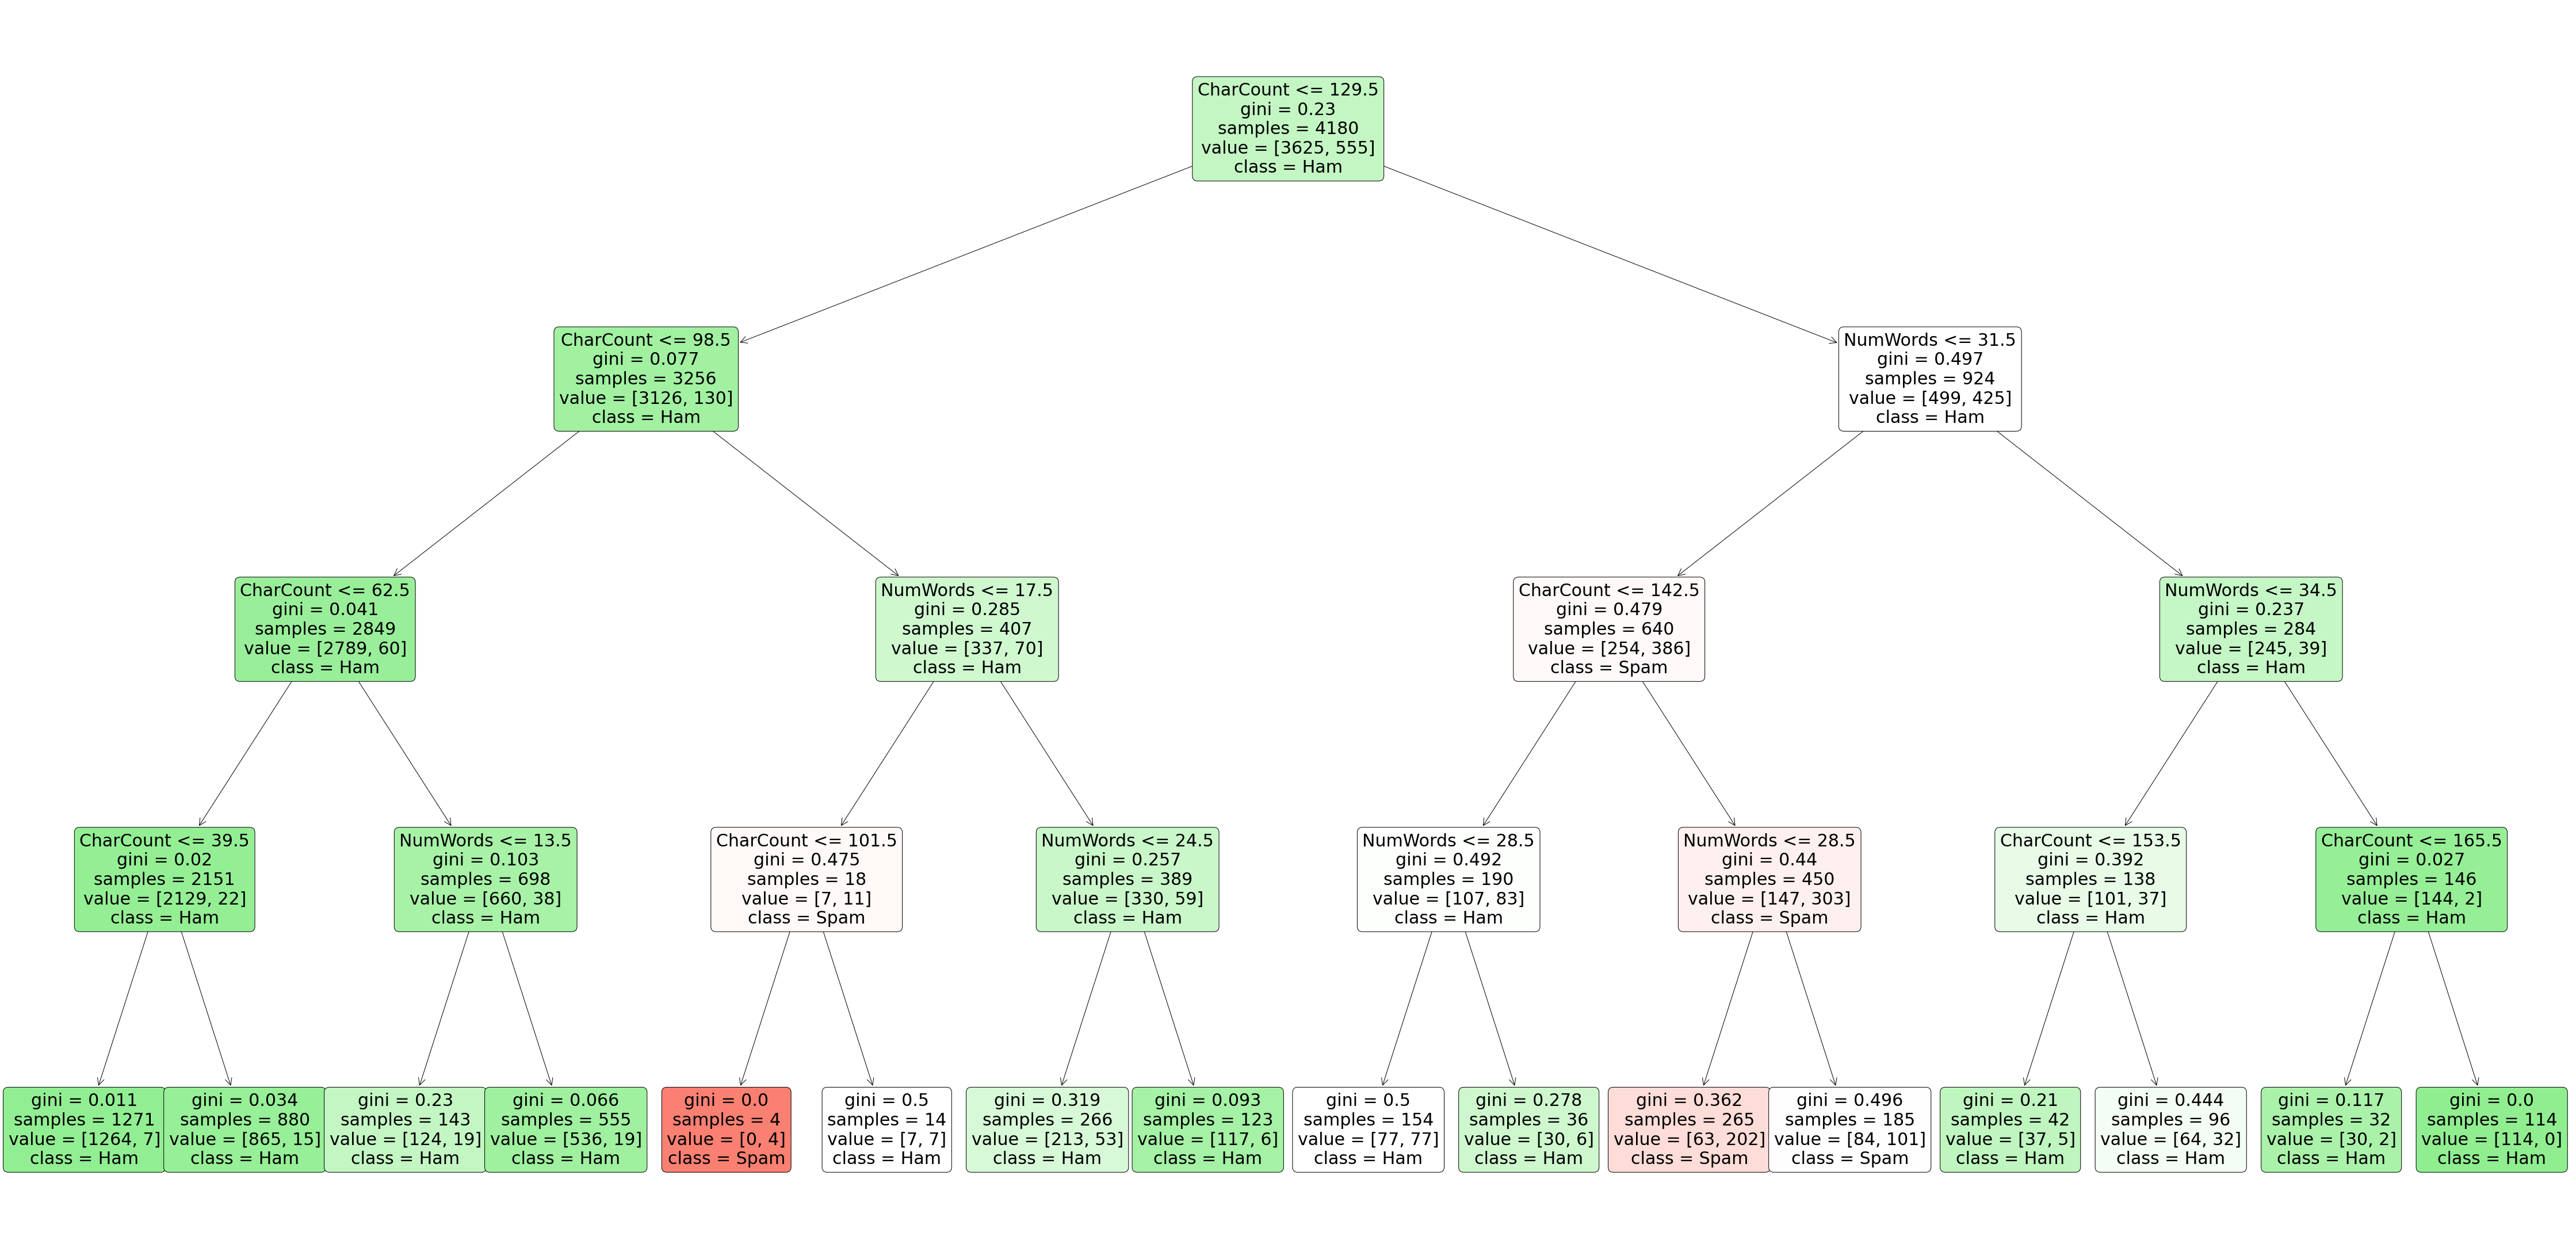

In [175]:
# Depth 4
genDecTree(4, x_train, x_test, y_train, y_test)

In [176]:
# Depth 6
genDecTree(6, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.919377990430622

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9031563845050216


In [177]:
# Depth 10
genDecTree(10, x_train, x_test, y_train, y_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9454545454545454

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8902439024390244
